# 实战案例1

   分析gs的人员信息

   先将用户数据加载进来

数据我存放到了我的github的priDataAnalyse仓库里面的


In [207]:
import pandas as pd

userInfos = pd.read_json('xcBaseUserInfo_20240814.json', lines=True)
# userInfos[1005:1007]

看看，有多少人

In [16]:
print("总人数：", len(userInfos))
print(userInfos.count())

总人数： 7472
id                    7472
userName              7472
loginName             7472
employNo              7472
mobile                5553
email                 4882
idCardNumber             0
picCode                  6
employLevel           7449
employeScore          7472
staffPostLevelName    7444
mainOrgId             7472
mainOrgName           7472
mainOrgFname          7472
companyName           7472
deptName              7472
deptId                7472
dtype: int64


删除没有意义的列

In [17]:
userInfos = userInfos.drop(columns=['idCardNumber'])
print(userInfos.columns)

Index(['id', 'userName', 'loginName', 'employNo', 'mobile', 'email', 'picCode',
       'employLevel', 'employeScore', 'staffPostLevelName', 'mainOrgId',
       'mainOrgName', 'mainOrgFname', 'companyName', 'deptName', 'deptId'],
      dtype='object')


不可能有7472个人， 应该包含了一些离职的人员，但是我的一个离职的同事其实不在里面

In [25]:
# 离职的guochao
userInfos[userInfos.employNo == 'XC19744']

,id,userName,loginName,employNo,mobile,email,idCardNumber,picCode,employLevel,employeScore,staffPostLevelName,mainOrgId,mainOrgName,mainOrgFname,companyName,deptName,deptId


我们来分组统计下，这个公司中岗位级别所占的人数

In [37]:
staff_post_level_count = userInfos.groupby('staffPostLevelName').size()
# 分组后按分组值排序
staff_post_level_count = staff_post_level_count.sort_values()
# staff_post_level_count = staff_post_level_count.sort_index()
staff_post_level_count

staffPostLevelName
一档 （M5+, S7+,T7+, P7+）              159
二档 （M1~M4, S4~S6, P4~P6, T4~T6）    1456
三档（S1~S3, P1~P2, T2~T3）            5829
dtype: int64

准备好画图工具matplotlib

In [42]:
import matplotlib
import matplotlib.pyplot as plt

# 中文显示问题 参考链接：https://blog.csdn.net/lemonbit/article/details/121433603
# matplotlib其实是不支持显示中文的 显示中文需要一行代码设置字体
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

可以从上面的数据看出，这个公司的岗位级别主要分为大的3档，每档里面有M线，S线，T线，P线

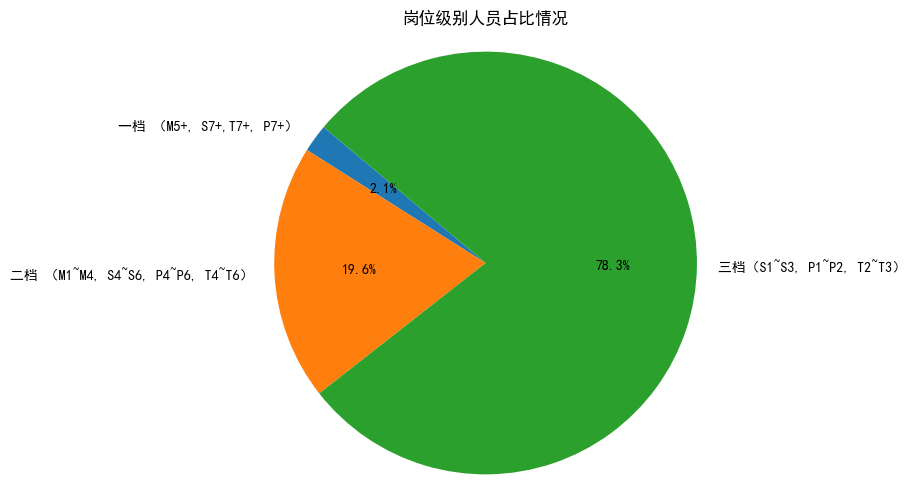

In [191]:
# 绘制饼图
plt.figure(figsize=(6, 6))
plt.pie(staff_post_level_count, labels=staff_post_level_count.index, autopct='%1.1f%%', startangle=140)
plt.title('岗位级别人员占比情况')
plt.axis('equal')  # 确保饼图是圆形
plt.show()

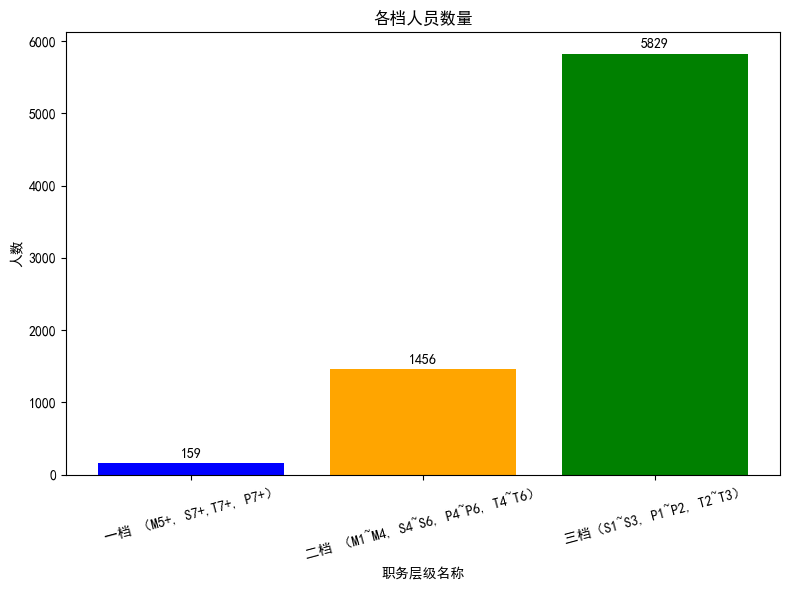

In [189]:
# 绘制柱状图
plt.figure(figsize=(8, 6))
plt.bar(staff_post_level_count.index, staff_post_level_count.values, color=['blue', 'orange', 'green'])

# 添加标题和标签
plt.title('各档人员数量')
plt.xlabel('职务层级名称')
plt.ylabel('人数')

# 显示每个柱子上的数值
for i, v in enumerate(staff_post_level_count):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')  # 在柱子上方显示人数

# 显示图形
plt.xticks(rotation=15)  # 旋转x轴标签以避免重叠
plt.tight_layout()       # 自动调整布局
plt.show()

In [73]:
score = pd.concat([userInfos['id'], userInfos['employeScore']], axis=1)
score[score['employeScore'] < 100][:5]

,id,employeScore
4737,50005447,85
4856,50003600,80
5413,50003729,80
5527,50005360,85
5727,50005267,85


这个员工分数是啥，为啥又55个人的分数低于100，但又没有高于100分的

In [2]:
# userInfos[userInfos.mainOrgName == '后端研发工程师'][['deptName','employNo','userName','staffPostLevelName']].sort_values(by='deptName', ascending=False)
# userInfos[userInfos.mainOrgName == '残疾人'][['deptName','employNo','userName','staffPostLevelName']].sort_values(by='deptName', ascending=False)

将大量的职位进行职位归类，保证所有的职位进行了职位归类

这里借助了文言一心帮我进行归类，下面是请求帮助的用语：

> 后续回答请使用中文回答，你看，下面的职位数据类别太多了，你能不能使用你的大脑将下面的同类职位进行合并：
> 
> 我给出一些合并后的类别：
> 
>   销售类、技术开发类、运维维护类、产品管理类、财务会计类、行政人事类、市场营销类、客户服务类、经营管理类、其它
> 
> 合并要求结果要求:
> 
> 1.结果格式信息：{ ”类别1“: ['职位列表'....], ”类别2“: ['职位列表'....], .....}；
> 
> 2.提供的数据不能漏掉一个职位；
> 
> 3.不要私自造不存在的数据；
> 
> 职位数据信息:
> 
> ["运营BP岗","技术支持组长", "质检专员", .....

数据上太多，就数据拆分后多次问，然后手动将结果汇总起来；

下面，将加工好的职位归类文件加载出来：

In [173]:
import json

# 将大量的职位进行职位归类
with open('jobMapping.json', 'r', encoding="utf-8") as file:  
    job_mapping_data = json.load(file)
job_mapping = dict()
for job_type, jobs in job_mapping_data.items():
    for job in jobs:
        job_mapping[job] = job_type

# 看一看是否还有没有映射过的职位
# all_job_set = set(job_mapping.keys())
# userInfos['mainOrgName'][~userInfos['mainOrgName'].isin(all_job_set)].drop_duplicates().to_json(force_ascii=False)

In [176]:
# 下面操作我绕了一下，没有直接映射后分组统计，是分组后，映射，分组求和，或许数据量性能更好
# 分组
main_org_name_size = userInfos.groupby('mainOrgName').size()
# Series转换为一个DataFrame
main_org_name_size = main_org_name_size.to_frame('count').reset_index()
# 职位归类
main_org_name_size['mainOrgName'] = main_org_name_size['mainOrgName'].map(job_mapping)
# 分组求和
main_org_name_size = main_org_name_size.groupby('mainOrgName')['count'].sum()
# 分组后按分组值排序
main_org_name_size = main_org_name_size.sort_values(ascending=False)
# 将某些岗位名称的合并
# print(main_org_name_size.index.to_list())
main_org_name_size

mainOrgName
销售类      2535
运维维护类    2397
行政人事类     509
经营管理类     460
其它        443
产品管理类     345
财务会计类     312
技术开发类     220
市场营销类     213
客户服务类      38
Name: count, dtype: int64

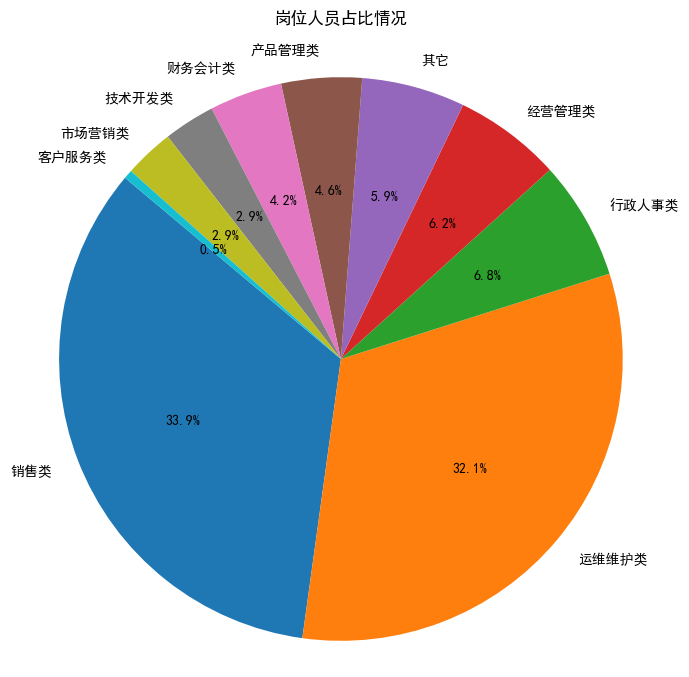

In [192]:
# 绘制饼图
plt.figure(figsize=(8, 8))
plt.pie(main_org_name_size, labels=main_org_name_size.index, autopct='%1.1f%%', startangle=140)
plt.title('岗位人员占比情况', pad=20)
plt.axis('equal')  # 确保饼图是圆形
plt.show()

从数据上能看到，此公司的确是一个主销售的销售型公司，除了销售外，老板眼里面都是成本部门，记得去年年会的时候，大老板下来对我们这层的技术人员说了一句：“鼓励大家到一线去当销售”。
上面运维维护类为什么占了这么多，我认为主要还是没有排除离职的一些人员，特别从公司创立以来，公司在全国各地都要安装广告屏幕，为广告屏幕进行维护，需要大量的人员，另外肯定薪酬肯定不会很高，会出现不断换血的情况，导致运维维护类人员较多。

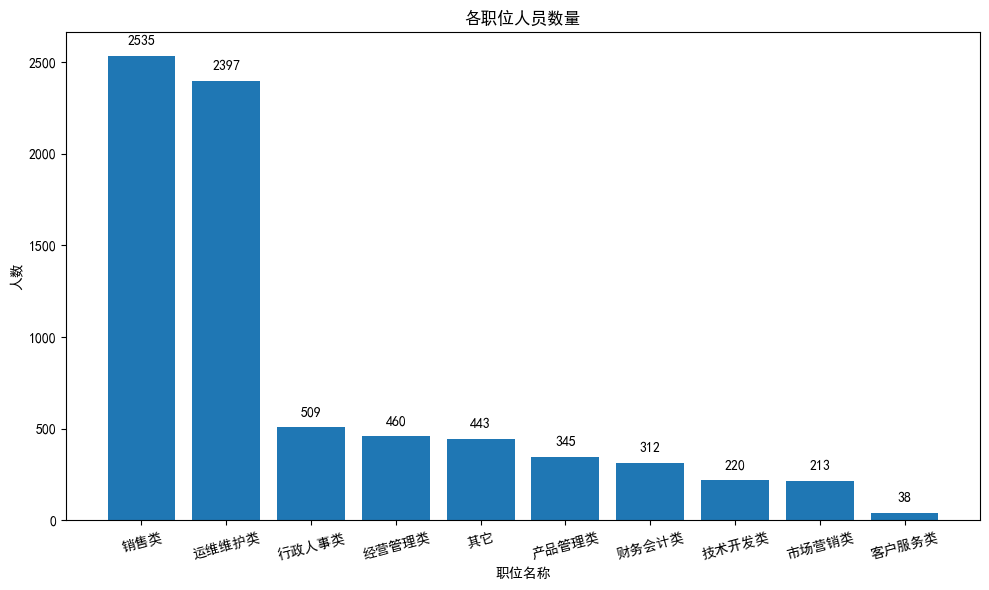

In [206]:
# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(main_org_name_size.index, main_org_name_size.values)

# 添加标题和标签
plt.title('各职位人员数量')
plt.xlabel('职位名称')
plt.ylabel('人数')

# 显示每个柱子上的数值
for i, v in enumerate(main_org_name_size):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')  # 在柱子上方显示人数

# 显示图形
plt.xticks(rotation=15)  # 旋转x轴标签以避免重叠
plt.tight_layout()       # 自动调整布局
plt.show()

In [3]:
# userInfos[userInfos.mainOrgName == 'IT专员'][['deptName','employNo','userName','staffPostLevelName', 'mainOrgFname']].sort_values(by='deptName', ascending=False)

分析下每个部门的人数

In [201]:
dept_name_count = userInfos.groupby('deptName').size()
# 分组后按分组值排序
dept_name_count = dept_name_count.sort_values(ascending=False)
dept_name_count[dept_name_count.values > 40]

deptName
开发部          356
维护部          308
安装部          276
经营一部         234
经营二部         205
产品支持部        165
销售支持部        128
经营三部         122
HRBP业务管理部    113
财务部          105
经营四部          99
行政部           91
总经办           84
经营六部          77
经营五部          72
经营第一事业部       56
开发一组          55
开发三组          49
产品质检部         49
文化部           48
产品开发部         46
开发二组          45
经营七部          43
质检部           42
销售一部          41
dtype: int64